## Setup

In [1]:
!pip uninstall tensorflow -yq
!pip install tensorflow-gpu gpustat -Uq
!gpustat

cf2a2d5fde91         Mon Dec 30 07:47:05 2019  418.67
[0] Tesla T4         | 43'C,   0 % |     0 / 15079 MB |


In [0]:
import numpy as np
import re, sys, csv, pickle
from sklearn.model_selection import train_test_split

import tensorflow.compat.v2 as tf
from tensorflow.keras import layers

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('seaborn-dark')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# CNN for Text Classification

In this notebook, we are going to do an end-to-end implemention of *Convolutional Neural Networks for Sentence Classification* (Yoon Kim, 2014).

In his [paper](https://arxiv.org/abs/1408.5882), Yoon Kim proposed several techniques to achieve good text classification accuracy with minimal hyper-parameter tuning.

This notebook consist of 4 main sections:

1. Preparing the data
2. Implementing Yoon Kim's CNN model
3. Training the model
4. Evaluating the model

In [0]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)

## Prepare the data

### Load Dataset

In [5]:
# download pre-trained GloVe vectors
GLOVE_URL = "https://github.com/OpenSUTD/machine-learning-workshop/releases/download/v0.0.01/glove.6B.100d.txt.zip"
GLOVE_DIR = tf.keras.utils.get_file("glove.6B.100d.txt.zip", GLOVE_URL, cache_subdir='datasets', extract=True)
print("GloVe data present at", GLOVE_DIR)
GLOVE_DIR = GLOVE_DIR.replace(".zip", "")

GloVe data present at /root/.keras/datasets/glove.6B.100d.txt.zip


In [0]:
def clean_text(text):
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    return text.strip().replace("  ", " ")

In [7]:
DATA_URL = "https://github.com/OpenSUTD/machine-learning-workshop/releases/download/v0.0.01/stanford_movie.zip"
DATA_DIR = tf.keras.utils.get_file("stanford_movie.zip", DATA_URL, cache_subdir='datasets', extract=True)
print("Dataset present at", DATA_DIR)
DATA_DIR = DATA_DIR.replace(".zip", "")

Dataset present at /root/.keras/datasets/stanford_movie.zip


In [0]:
texts, labels = [], [] # empty lists for the sentences and labels

data_neg = open(DATA_DIR+"/stanford_movie_neg.txt", "r", encoding="latin-1") 
for line in data_neg: 
    texts.append(clean_text(line))
    labels.append(int(0))

In [0]:
data_pos = open(DATA_DIR+"/stanford_movie_pos.txt", "r", encoding="latin-1") 
for line in data_pos: 
    texts.append(clean_text(line))
    labels.append(int(1))

In [10]:
print("Sample negative:", texts[0], labels[0])
print("Sample positive:", texts[-1], labels[-1])

Sample negative: simplistic silly and tedious 0
Sample positive: provides a porthole into that noble trembling incoherence that defines us all 1


### Create Word Tokenizer

In [11]:
try:
    with open('tokenizer.pickle', 'rb') as f:
        tokenizer = pickle.load(f)
        print("Using cached tokenizer")
except Exception as e:
    print(e)
    print("Creating new tokenizer")
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("[i] Saved word tokenizer to file: tokenizer.pickle")

Using cached tokenizer


**Generate the array of sequences from dataset**

In [12]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Vocabulary size:', len(word_index))

# pad on both ends
data_int = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                         padding='pre',
                                                         maxlen=(MAX_SEQUENCE_LENGTH-5))
data = tf.keras.preprocessing.sequence.pad_sequences(data_int,
                                                     padding='post',
                                                     maxlen=(MAX_SEQUENCE_LENGTH))

[i] Vocabulary size: 20501


### Train-Validation split

In [13]:
# convert the category label to one-hot encoding
labels = tf.keras.utils.to_categorical(np.asarray(labels))
print('[i] Shape of data tensor:', data.shape)
print('[i] Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels,
                                                  test_size=VALIDATION_SPLIT)

print('[i] Number of entries in each category:')
print("[+] Training:", y_train.sum(axis=0))
print("[+] Validation:", y_val.sum(axis=0))

[i] Shape of data tensor: (10662, 30)
[i] Shape of label tensor: (10662, 2)
[i] Number of entries in each category:
[+] Training: [4286. 4243.]
[+] Validation: [1045. 1088.]


### Inspecting the data

In [14]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1118  290    3  614    0    0    0
    0    0]

One-hot label:
 [1. 0.]


## Create the Model

Yoon Kim's model has several notable features:

* two sets of word embeddings for what he terms a **"multi-channel" approach**.
  * One of the word embeddings will be frozen (**"static channel"**), and one will be modified during the training process (**"non-static channel"**). 
* multiple convolutional kernel sizes

We will now start to create the model in Tensorflow 2.0 using `tf.keras`.

**Load word embeddings into an `embeddings_index`**
Create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.

We use a set from [pre-trained GloVe vectors from Stanford](https://nlp.stanford.edu/projects/glove/).

In [15]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] (long) Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(" Completed!")

[i] (long) Loading GloVe from: /root/.keras/datasets/glove.6B.100d.txt ...Done.
[+] Proceeding with Embedding Matrix... Completed!


In [0]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector

**Create the `Embedding` layers**

In [0]:
sequence_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # input to the model

# static channel
embedding_layer_frozen = layers.Embedding(len(word_index) + 1,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = layers.Embedding(len(word_index) + 1,
                                         EMBEDDING_DIM,
                                         weights=[embedding_matrix_ns],
                                         input_length=MAX_SEQUENCE_LENGTH,
                                         trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

l_embed = layers.Concatenate(axis=1)([embedded_sequences_frozen, embedded_sequences_train])

**Create the CNN layer with multiple kernel (filter) sizes**

In [0]:
l_conv_3 = layers.Conv1D(filters=32,kernel_size=3,activation='relu')(l_embed)
l_conv_4 = layers.Conv1D(filters=32,kernel_size=4,activation='relu')(l_embed)
l_conv_5 = layers.Conv1D(filters=32,kernel_size=5,activation='relu')(l_embed)

l_conv = layers.Concatenate(axis=1)([l_conv_3, l_conv_4, l_conv_5])

Followed by the rest of the model (boring!!)

In [0]:
l_pool = layers.MaxPooling1D(4)(l_conv)
l_drop = layers.Dropout(0.5)(l_pool)
l_flat = layers.Flatten()(l_drop)
l_dense = layers.Dense(32, activation='relu')(l_flat)
preds = layers.Dense(2, activation='softmax')(l_dense) #follows the number of classes

**Compile the model into a static graph for training**

In [20]:
model = tf.keras.models.Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      2050200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      2050200     input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 100)      0           embedding[0][0]                  
                                                                 embedding_1[0][0]            

### Model Visualisation

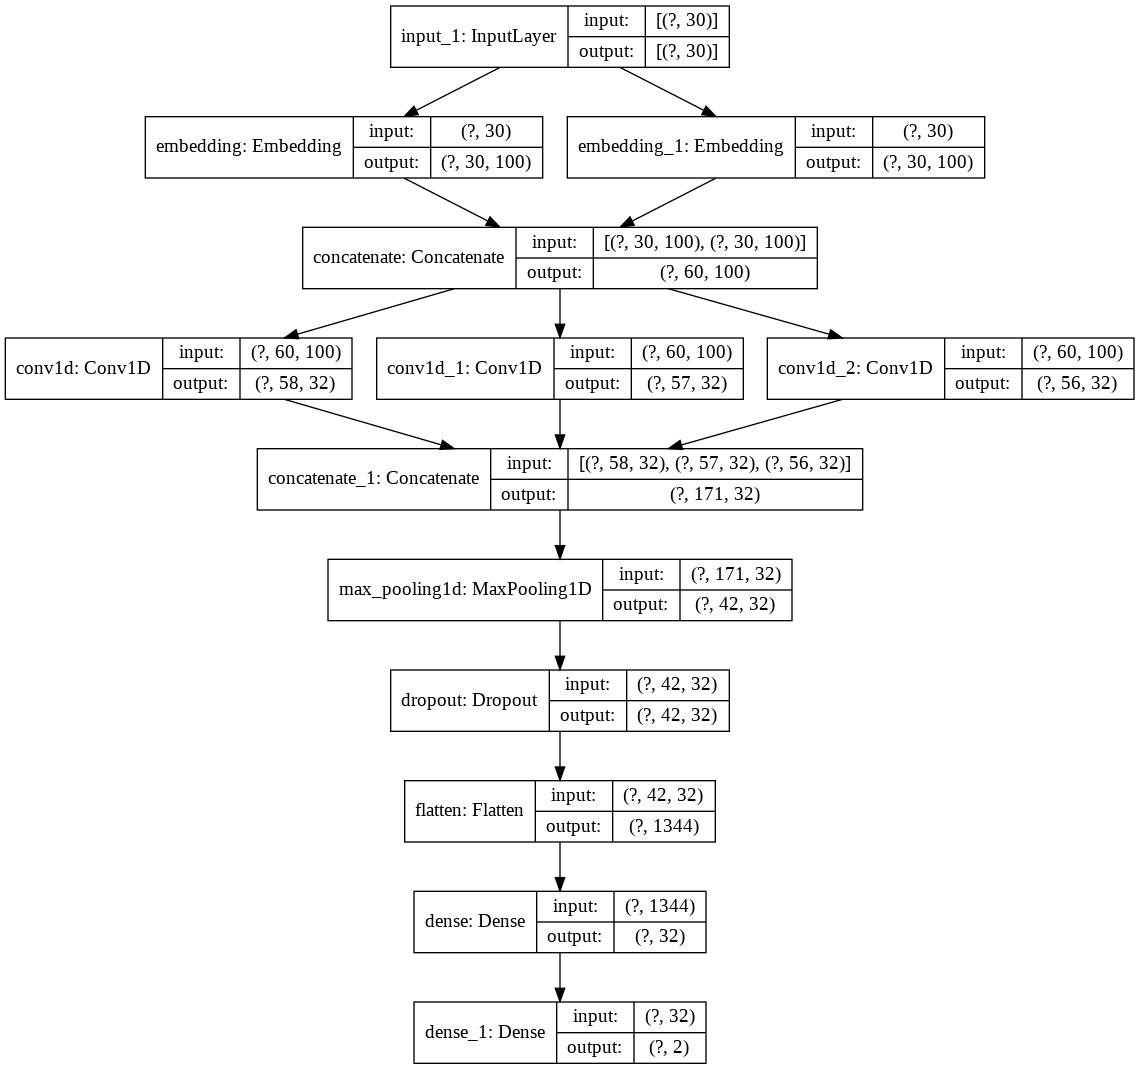

In [21]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Train the Model

In [0]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",
                                                      monitor='val_loss',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=True,)

In [24]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      callbacks=[model_checkpoint],
                      epochs=10, batch_size=64)

Training Progress:
Train on 8529 samples, validate on 2133 samples
Epoch 1/10
8448/8529 [============================>.] - ETA: 0s - loss: 0.7157 - acc: 0.5186
Epoch 00001: val_loss improved from inf to 0.68836, saving model to best_weights.h5
8529/8529 [==============================] - 7s 866us/sample - loss: 0.7153 - acc: 0.5202 - val_loss: 0.6884 - val_acc: 0.5663
Epoch 2/10
8512/8529 [============================>.] - ETA: 0s - loss: 0.6383 - acc: 0.6319
Epoch 00002: val_loss improved from 0.68836 to 0.57107, saving model to best_weights.h5
8529/8529 [==============================] - 4s 446us/sample - loss: 0.6382 - acc: 0.6321 - val_loss: 0.5711 - val_acc: 0.7037
Epoch 3/10
8512/8529 [============================>.] - ETA: 0s - loss: 0.5127 - acc: 0.7478
Epoch 00003: val_loss improved from 0.57107 to 0.52155, saving model to best_weights.h5
8529/8529 [==============================] - 4s 443us/sample - loss: 0.5126 - acc: 0.7478 - val_loss: 0.5216 - val_acc: 0.7436
Epoch 4/10
85

In [0]:
model.load_weights("best_weights.h5")

## Evaluate the Model

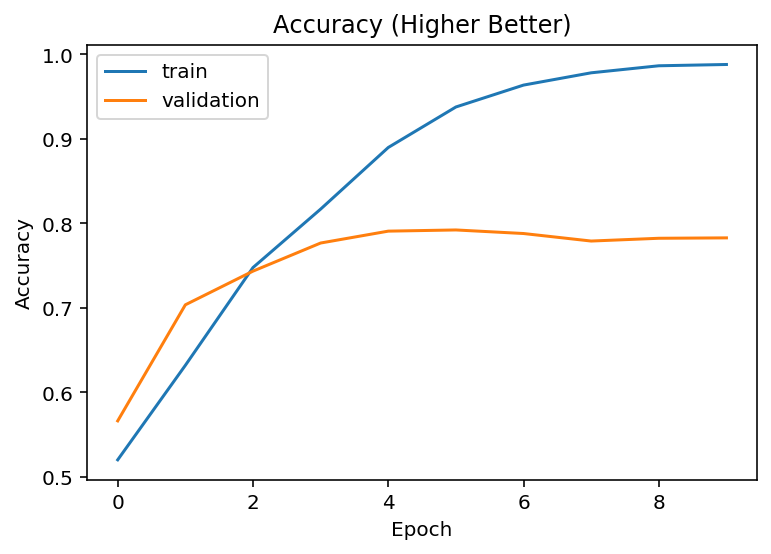

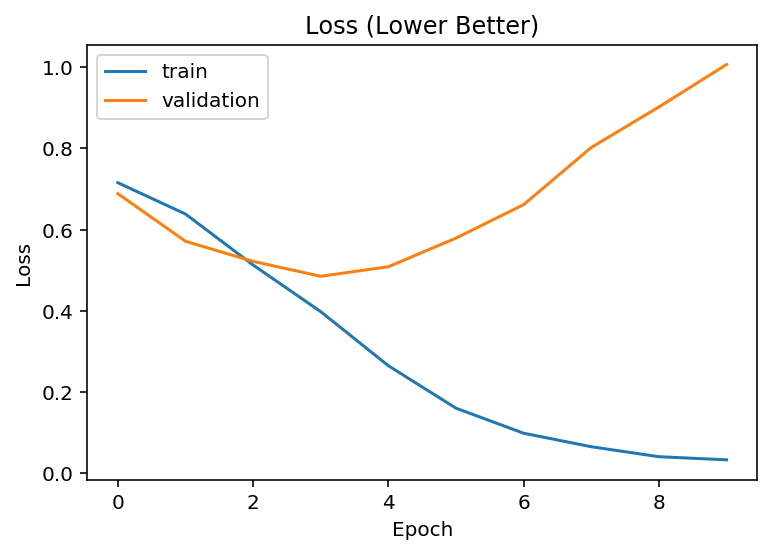

In [26]:
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

classes = ["positive", "negative"]

In [28]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    positive       0.77      0.77      0.77      1045
    negative       0.78      0.78      0.78      1088

    accuracy                           0.78      2133
   macro avg       0.78      0.78      0.78      2133
weighted avg       0.78      0.78      0.78      2133



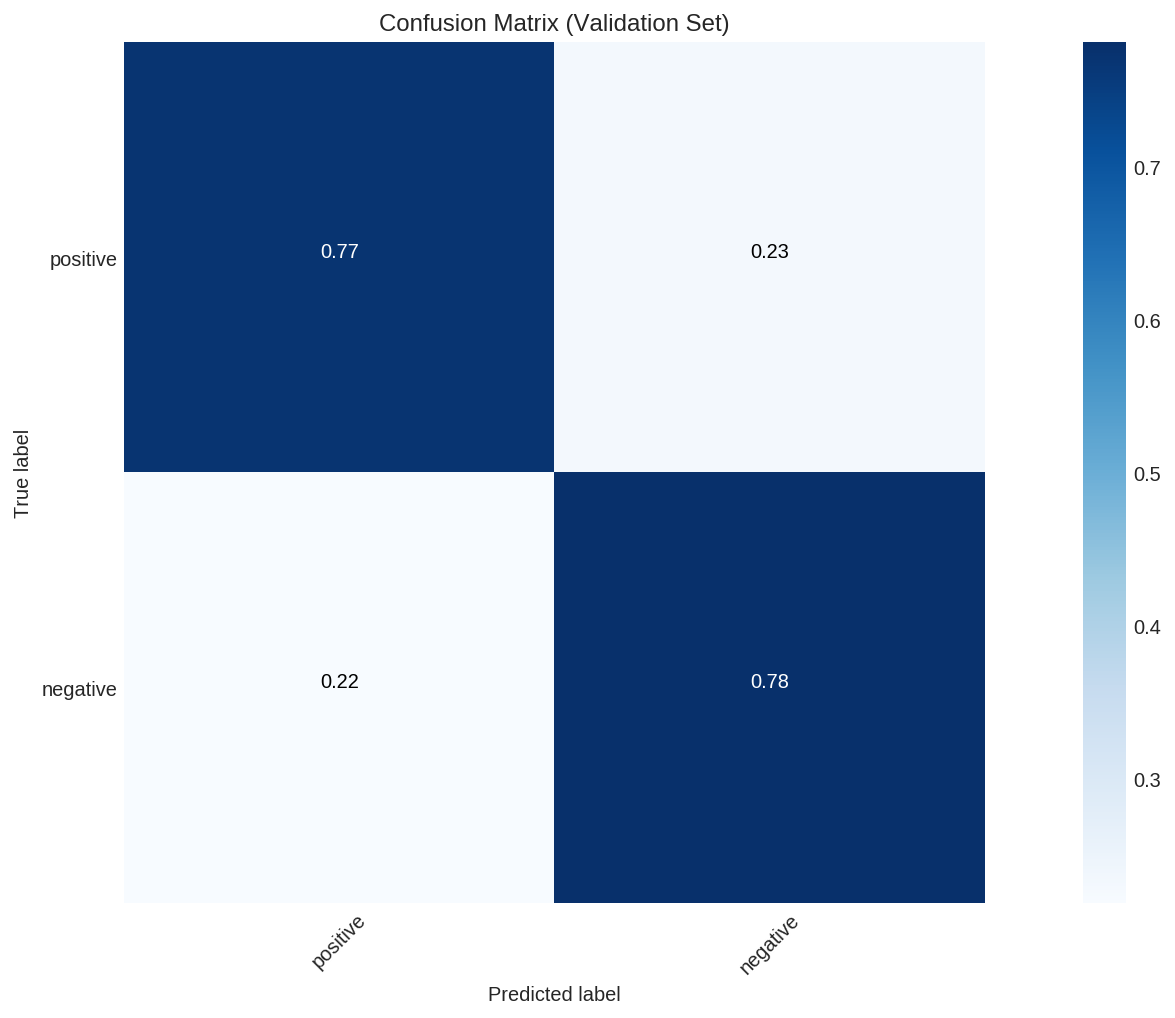

In [29]:
plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)